<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Black_Scholes_Vertical_Spread_Option_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
roi = 0.06
div_yield = 0.02
volatility = 0.3
time_to_expiry = 6/12

In [3]:
def black_scholes(data_df, call_name, strike_price, time_to_expiry, volatility, roi, div_yield):
    K = strike_price
    sigma = volatility
    r = roi
    q = div_yield
    tau = time_to_expiry

    if call_name == "deeper_itm":
        put_name = "deeper_otm"

    if call_name == "deep_itm":
        put_name = "deep_otm"

    if call_name == "itm":
        put_name = "otm"

    if call_name == "atm":
        put_name = "atm"

    if call_name == "otm":
        put_name = "itm"

    if call_name == "deep_otm":
        put_name = "deep_itm"

    if call_name == "deeper_otm":
        put_name = "deeper_itm"

    data_df.eval('temp = log(S) - log(@K) + (@r - @q) * @tau', inplace = True)
    data_df.eval('d_plus_num = temp + 0.5 * @tau * @sigma ** 2', inplace = True)
    data_df.eval('d_minus_num = temp - 0.5 * @tau * @sigma ** 2', inplace = True)
    data_df.eval('d_den = @sigma * sqrt(@tau)', inplace = True)
    data_df.eval('d_plus = d_plus_num / d_den', inplace = True)
    data_df.eval('d_minus = d_minus_num / d_den', inplace = True)

    data_df['cdf_norm_d_plus'] = data_df['d_plus'].apply(lambda t : norm.cdf(t))
    data_df['cdf_norm_d_minus'] = data_df['d_minus'].apply(lambda t : norm.cdf(t))
    data_df['cdf_norm_neg_d_plus'] = data_df['d_plus'].apply(lambda t : norm.cdf(-t))
    data_df['cdf_norm_neg_d_minus'] = data_df['d_minus'].apply(lambda t : norm.cdf(-t))

    data_df.eval('call = S * exp(-@q * @tau) * cdf_norm_d_plus - @K * exp(-@r * @tau) * cdf_norm_d_minus', inplace = True)
    data_df.eval('put = @K * exp(-@r * @tau) * cdf_norm_neg_d_minus - S * exp(-@q * @tau) * cdf_norm_neg_d_plus', inplace = True)
    data_df.eval(f'{call_name}_call_premium = call', inplace = True)
    data_df.eval(f'{put_name}_put_premium = put', inplace = True)

    data_df[f'{call_name}_call_payoff'] = data_df['S'].apply(lambda t : t - K if t > K else 0)
    data_df[f'{put_name}_put_payoff'] = data_df['S'].apply(lambda t : K - t if t < K else 0)

    return data_df

In [4]:
def bull_call_spread(time_to_expiry, volatility, roi, div_yield):
    data_df = pd.DataFrame({
        'S' : np.linspace(start = 0, stop = 1000, num = 2000 + 1, endpoint = True)
    })

    black_scholes(data_df, "deeper_itm", 100, time_to_expiry, volatility, roi, div_yield)
    black_scholes(data_df, "deep_itm", 200, time_to_expiry, volatility, roi, div_yield)
    black_scholes(data_df, "itm", 400, time_to_expiry, volatility, roi, div_yield)
    black_scholes(data_df, "atm", 500, time_to_expiry, volatility, roi, div_yield)
    black_scholes(data_df, "otm", 600, time_to_expiry, volatility, roi, div_yield)
    black_scholes(data_df, "deep_otm", 800, time_to_expiry, volatility, roi, div_yield)
    black_scholes(data_df, "deeper_otm", 900, time_to_expiry, volatility, roi, div_yield)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'bull_call_spread_{suffix} = itm_call_{suffix} - atm_call_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'bear_call_spread_{suffix} = otm_call_{suffix} - atm_call_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'deep_bull_call_spread_{suffix} = deep_itm_call_{suffix} - itm_call_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'deep_bear_call_spread_{suffix} = deep_otm_call_{suffix} - otm_call_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'deeper_bull_call_spread_{suffix} = deeper_itm_call_{suffix} - deep_itm_call_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'deeper_bear_call_spread_{suffix} = deeper_otm_call_{suffix} - deep_otm_call_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'bear_put_spread_{suffix} = itm_put_{suffix} - atm_put_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'bull_put_spread_{suffix} = otm_put_{suffix} - atm_put_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'deep_bear_put_spread_{suffix} = deep_itm_put_{suffix} - itm_put_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'deep_bull_put_spread_{suffix} = deep_otm_put_{suffix} - otm_put_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'deeper_bear_put_spread_{suffix} = deeper_itm_put_{suffix} - deep_itm_put_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'deeper_bull_put_spread_{suffix} = deeper_otm_put_{suffix} - deep_otm_put_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'call_butterfly_{suffix} = bull_call_spread_{suffix} + bear_call_spread_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'call_condor_{suffix} = deep_bull_call_spread_{suffix} + deep_bear_call_spread_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'deep_call_condor_{suffix} = deeper_bull_call_spread_{suffix} + deeper_bear_call_spread_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'call_castle_{suffix} = deep_call_condor_{suffix} + call_butterfly_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'put_butterfly_{suffix} = bull_put_spread_{suffix} + bear_put_spread_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'put_condor_{suffix} = deep_bull_put_spread_{suffix} + deep_bear_put_spread_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'deep_put_condor_{suffix} = deeper_bull_put_spread_{suffix} + deeper_bear_put_spread_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'put_castle_{suffix} = deep_put_condor_{suffix} + put_butterfly_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'debit_ironfly_{suffix} = bull_call_spread_{suffix} + bear_put_spread_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'debit_ironcondor_{suffix} = deep_bull_call_spread_{suffix} + deep_bear_put_spread_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'deep_debit_ironcondor_{suffix} = deeper_bull_call_spread_{suffix} + deeper_bear_put_spread_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'debit_ironcastle_{suffix} = deep_debit_ironcondor_{suffix} + debit_ironfly_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'credit_ironfly_{suffix} = bull_put_spread_{suffix} + bear_call_spread_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'credit_ironcondor_{suffix} = deep_bull_put_spread_{suffix} + deep_bear_call_spread_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'deep_credit_ironcondor_{suffix} = deeper_bull_put_spread_{suffix} + deeper_bear_call_spread_{suffix}', inplace = True)

    for suffix in ['payoff', 'premium']:
        data_df.eval(f'credit_ironcastle_{suffix} = deep_credit_ironcondor_{suffix} + credit_ironfly_{suffix}', inplace = True)

    return data_df

In [5]:
spread_1_df = bull_call_spread(6, volatility, roi, div_yield)
spread_2_df = bull_call_spread(5, volatility, roi, div_yield)
spread_3_df = bull_call_spread(4, volatility, roi, div_yield)
spread_4_df = bull_call_spread(3, volatility, roi, div_yield)
spread_5_df = bull_call_spread(2, volatility, roi, div_yield)
spread_6_df = bull_call_spread(1, volatility, roi, div_yield)

In [8]:
def plot_chart(plot_title, prefix):
    sns.lineplot(x = 'S', y = f'{prefix}_payoff', data = spread_1_df, color = 'black', label = 'At expiry')
    sns.lineplot(x = 'S', y = f'{prefix}_premium', data = spread_1_df, color = 'violet', label = '6 years expiry')
    sns.lineplot(x = 'S', y = f'{prefix}_premium', data = spread_2_df, color = 'blue', label = '5 years expiry')
    sns.lineplot(x = 'S', y = f'{prefix}_premium', data = spread_3_df, color = 'green', label = '4 years expiry')
    sns.lineplot(x = 'S', y = f'{prefix}_premium', data = spread_4_df, color = 'yellow', label = '3 years expiry')
    sns.lineplot(x = 'S', y = f'{prefix}_premium', data = spread_5_df, color = 'orange', label = '2 years expiry')
    sns.lineplot(x = 'S', y = f'{prefix}_premium', data = spread_6_df, color = 'red', label = '1 year expiry')
    plt.grid(alpha=0.3)
    plt.axhline(0, linestyle = '--', color = 'black')
    plt.axvline(500, ymin = 0, ymax = 1, linestyle = '--', color = 'black')
    plt.text(500 + 0.5, 0, 'At the money',rotation=90)
    plt.xlabel('Spot Price')
    plt.ylabel('Option Premium')
    plt.title(plot_title)

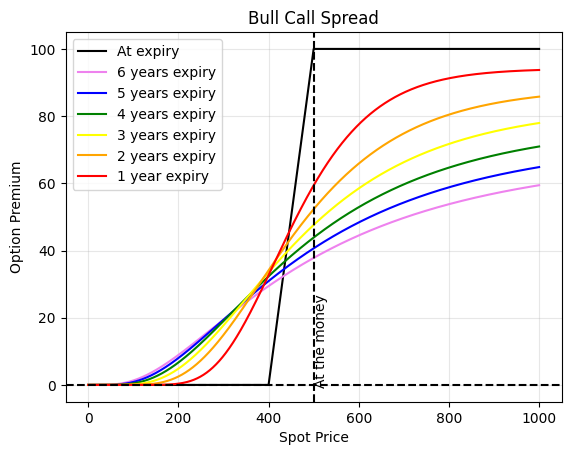

In [9]:
plot_chart("Bull Call Spread", "bull_call_spread")

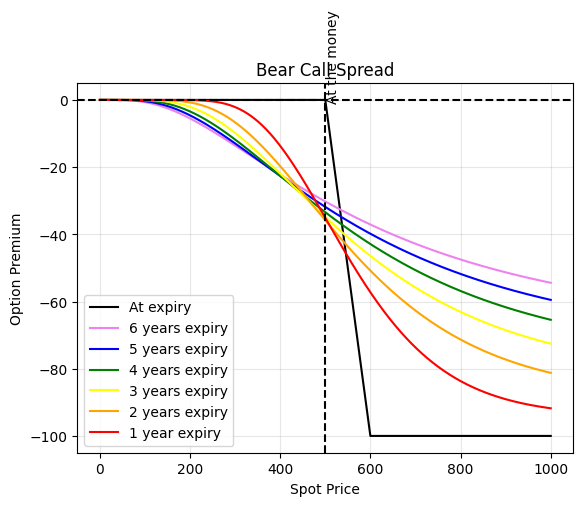

In [10]:
plot_chart("Bear Call Spread", "bear_call_spread")

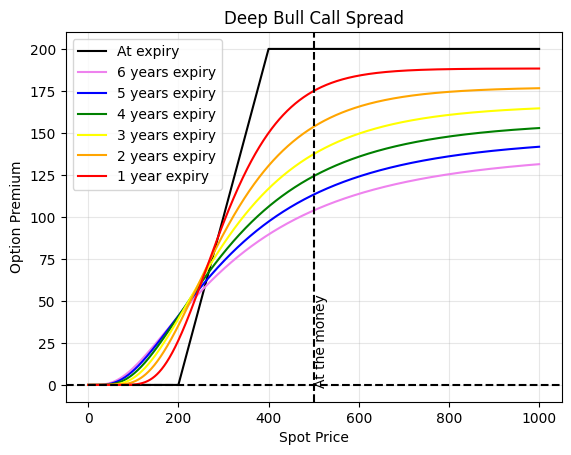

In [11]:
plot_chart("Deep Bull Call Spread", "deep_bull_call_spread")

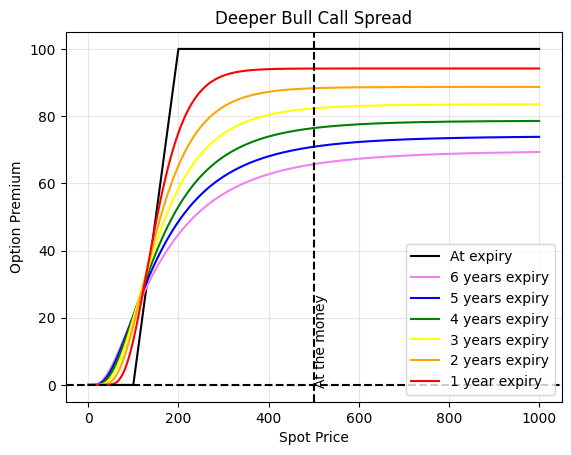

In [12]:
plot_chart("Deeper Bull Call Spread", "deeper_bull_call_spread")

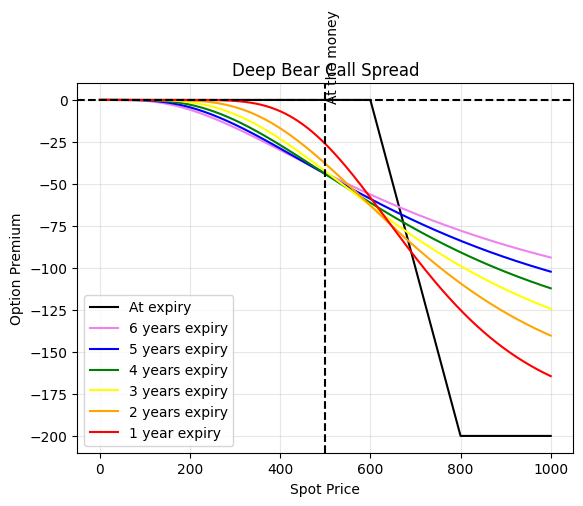

In [13]:
plot_chart("Deep Bear Call Spread", "deep_bear_call_spread")

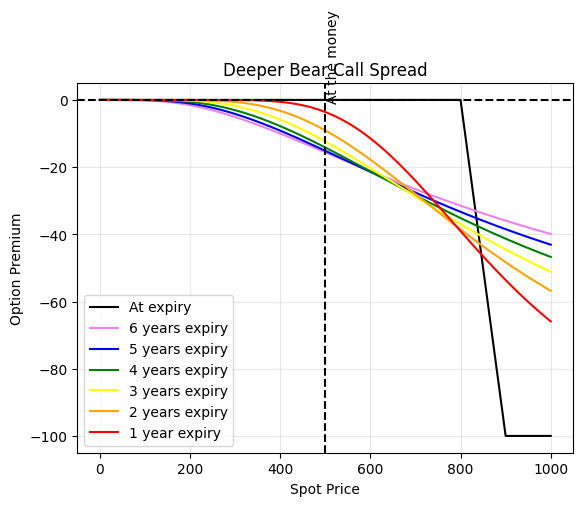

In [14]:
plot_chart("Deeper Bear Call Spread", "deeper_bear_call_spread")

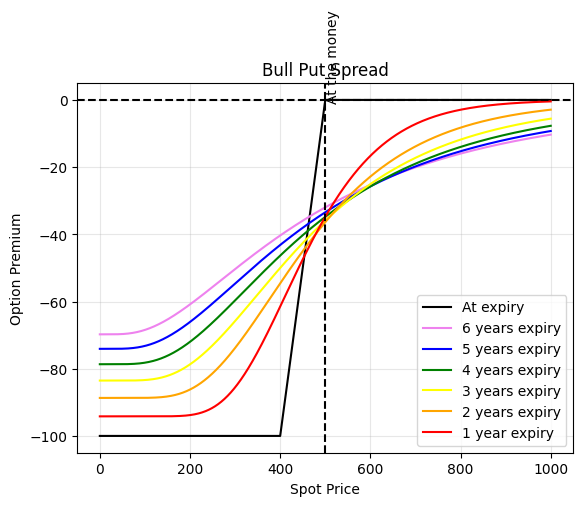

In [15]:
plot_chart("Bull Put Spread", "bull_put_spread")

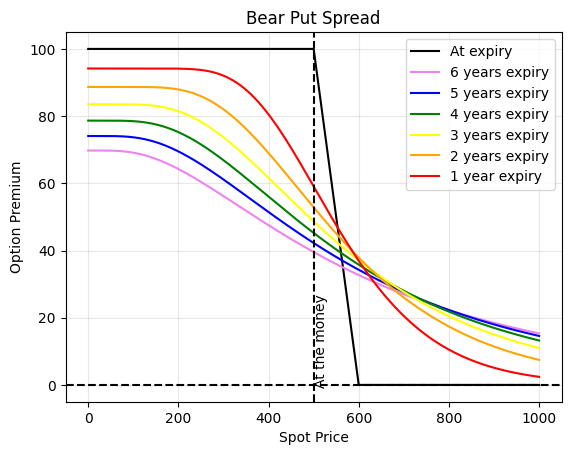

In [16]:
plot_chart("Bear Put Spread", "bear_put_spread")

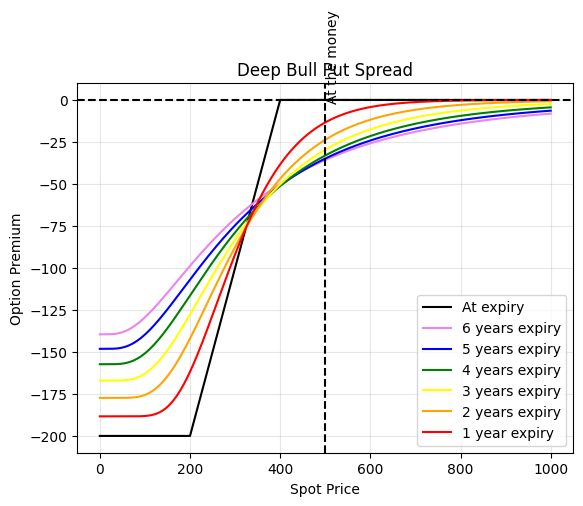

In [17]:
plot_chart("Deep Bull Put Spread", "deep_bull_put_spread")

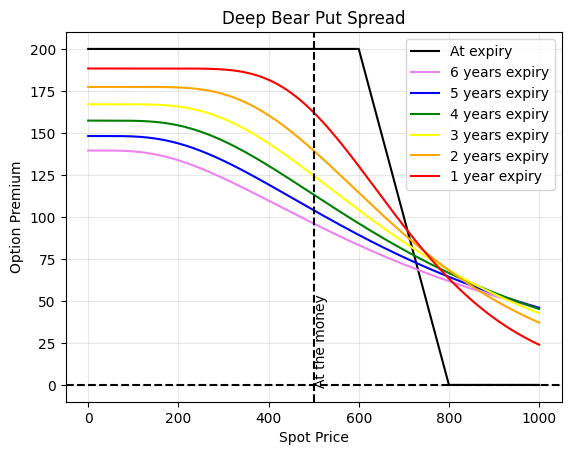

In [18]:
plot_chart("Deep Bear Put Spread", "deep_bear_put_spread")

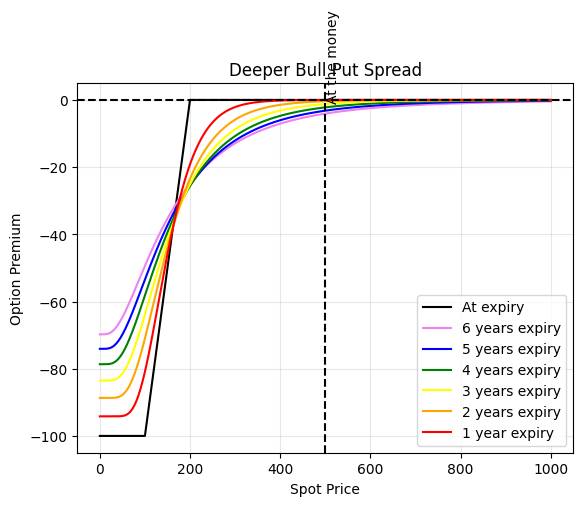

In [19]:
plot_chart("Deeper Bull Put Spread", "deeper_bull_put_spread")

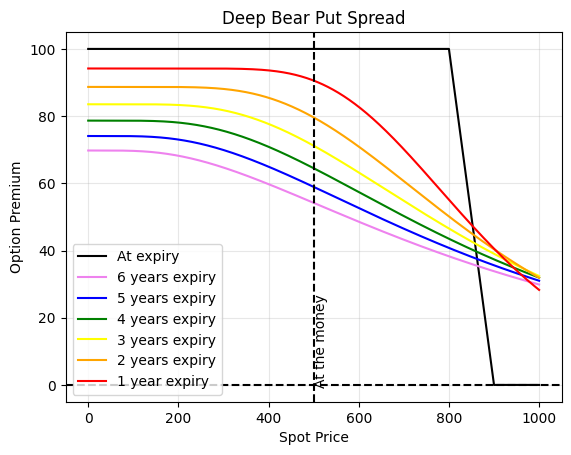

In [20]:
plot_chart("Deep Bear Put Spread", "deeper_bear_put_spread")

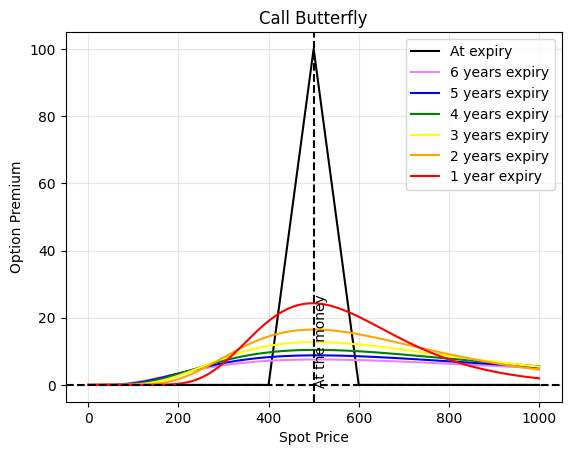

In [21]:
plot_chart("Call Butterfly", "call_butterfly")

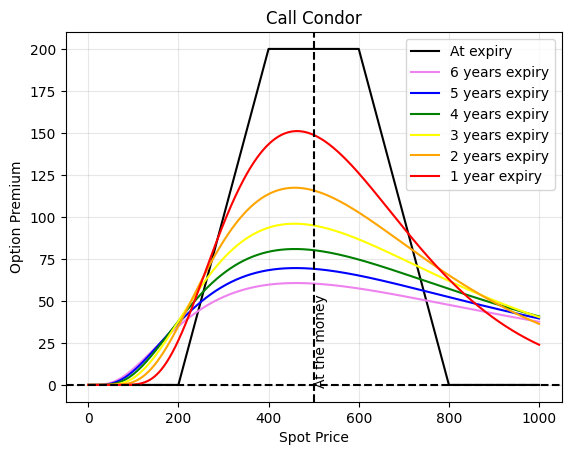

In [22]:
plot_chart("Call Condor", "call_condor")

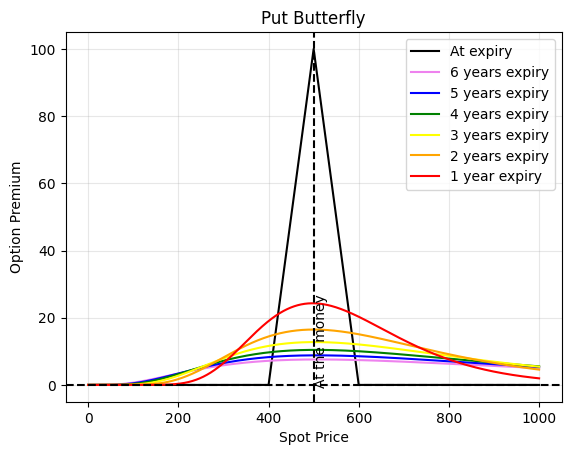

In [23]:
plot_chart("Put Butterfly", "put_butterfly")

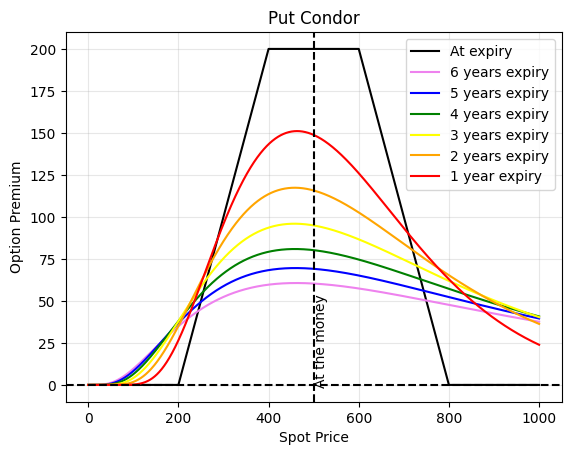

In [24]:
plot_chart("Put Condor", "put_condor")

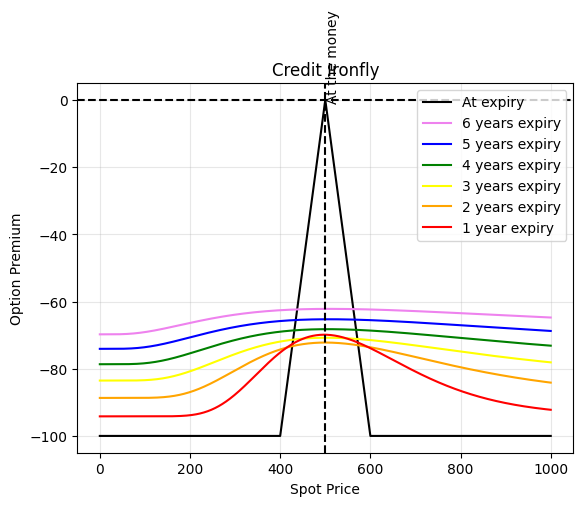

In [25]:
plot_chart("Credit Ironfly", "credit_ironfly")

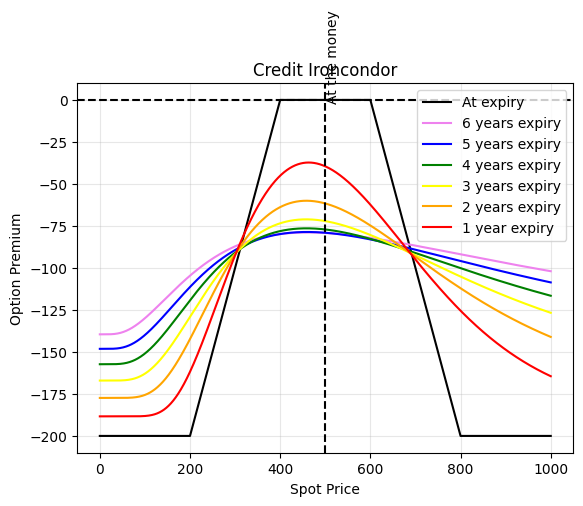

In [26]:
plot_chart("Credit Ironcondor", "credit_ironcondor")

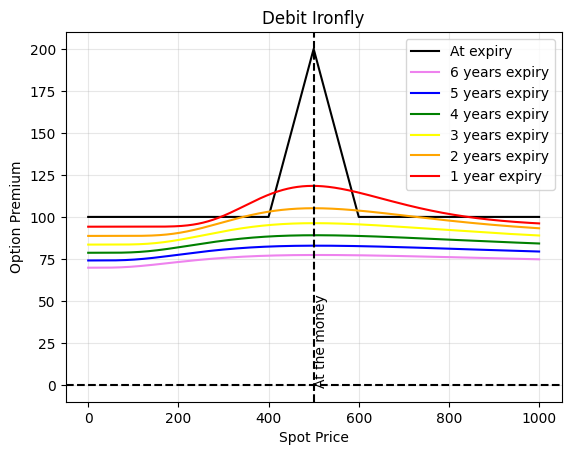

In [27]:
plot_chart("Debit Ironfly", "debit_ironfly")

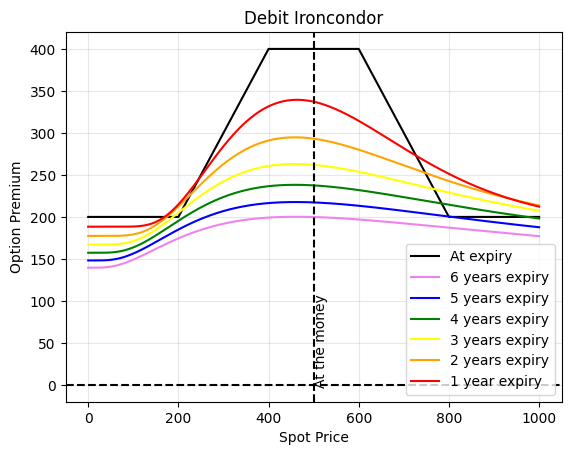

In [28]:
plot_chart("Debit Ironcondor", "debit_ironcondor")

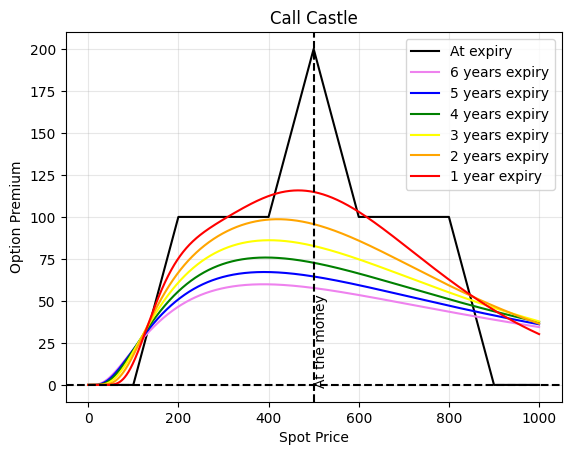

In [29]:
plot_chart("Call Castle", "call_castle")

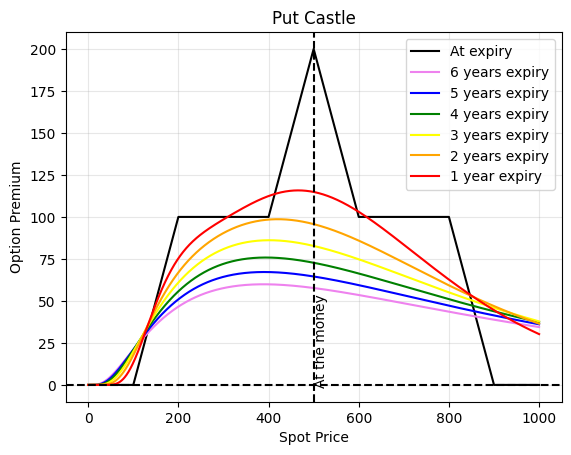

In [30]:
plot_chart("Put Castle", "put_castle")

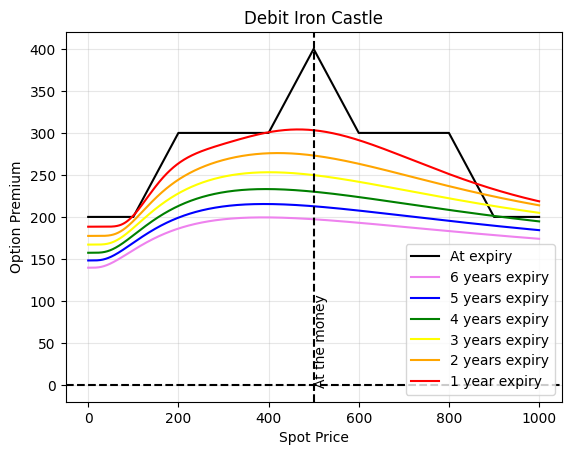

In [31]:
plot_chart("Debit Iron Castle", "debit_ironcastle")

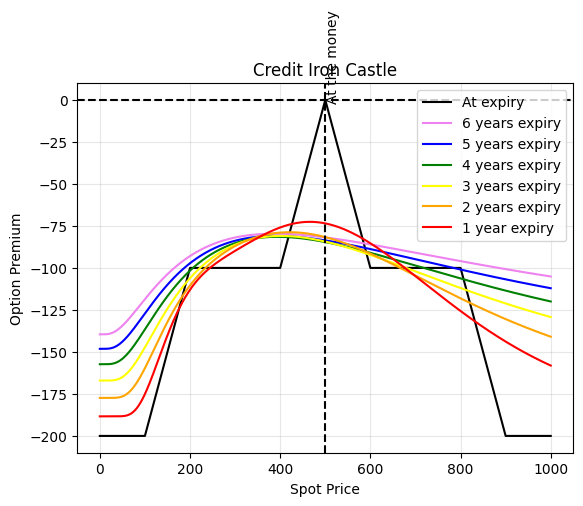

In [32]:
plot_chart("Credit Iron Castle", "credit_ironcastle")